<a href="https://colab.research.google.com/github/arnauldnzegha/Deep-Learning-Models-Compression-for-Agri-Plants./blob/main/Inception_CompressionForPlant_pruning_Manuel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning model compression for agricultural devices

## Pruning and Quatization of Inception and test on PlantVillage

Installation of TF 2.x

In [ ]:
from __future__ import division, print_function, absolute_import
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Convolution2D, Input, Dropout, Activation, GlobalAveragePooling2D,concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.regularizers import l2
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.utils import np_utils
import keras.backend.tensorflow_backend as K

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
#from kerassurgeon.operations import delete_layer, insert_layer, delete_channels

from random import seed
from random import randint
seed(1234)

Using TensorFlow backend.


## This code load PlantVille from My googleDrinve

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
zip_id = '100AqPztziZQCyaRvW80WlE2RNbpCiXok'
if not os.path.exists('DATA'):
    os.makedirs('DATA')
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('data.zip')
zip_ref = zipfile.ZipFile('data.zip', 'r')
zip_ref.extractall('DATA/')
zip_ref.close()



This fonction return the content of the dataset

In [ ]:

def load_plantVillage(rootDir,dim=(50,50)):
    root=rootDir
    folders = os.listdir(root)
    nb = len(folders)
    x_data=[]
    y_label=[]
    xt_data=[]
    yt_label=[]
    print(nb)
    for x in range(nb):
        label=np.zeros(nb)
        label[x]=1
        PlantPath=os.listdir(root+"/"+folders[x])
        plants=[root+"/"+folders[x]+"/"+f for f in PlantPath if (f.endswith(".png") or f.endswith(".jpg") or f.endswith(".JPG"))]
        i=0
        for plant in plants:
            imgs=cv2.imread(plant)
            imgs= cv2.resize(imgs, dim)
            if(i%5==0):
                xt_data.extend([imgs])
                yt_label.extend([label])
            else:
                x_data.extend([imgs])
                y_label.extend([label])
            i=i+1
    return (np.asarray(x_data), np.asarray(y_label), np.asarray(xt_data), np.asarray(yt_label), nb)


##Inception
#inception block

In [ ]:
def inception_block(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [ ]:
from keras.initializers import glorot_uniform
from keras.initializers import Constant

kernel_init = glorot_uniform()
bias_init = Constant(value=0.2)

# inception Model

In [ ]:
def my_inception(dim=75):
    input_layer = Input(shape=(dim, dim, 3))
    x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init,bias_initializer=bias_init)(input_layer)
    x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
    x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
    x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
    x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)
    x=BatchNormalization()(x)
    x = inception_block(x,
                            filters_1x1=64,
                            filters_3x3_reduce=96,
                            filters_3x3=128,
                            filters_5x5_reduce=16,
                            filters_5x5=32,
                            filters_pool_proj=32,
                            name='inception_3a')
    x=BatchNormalization()(x)
    x = inception_block(x,
                         filters_1x1=128,
                         filters_3x3_reduce=128,
                         filters_3x3=192,
                         filters_5x5_reduce=32,
                         filters_5x5=96,
                         filters_pool_proj=64,
                         name='inception_3b')
    
    x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)
    x=BatchNormalization()(x)
    x = inception_block(x,
                          filters_1x1=192,
                          filters_3x3_reduce=96,
                          filters_3x3=208,
                          filters_5x5_reduce=16,
                          filters_5x5=48,
                          filters_pool_proj=64,
                          name='inception_4a')
    
    x1 = AveragePooling2D((5, 5), strides=3)(x)
    x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
    x1 = Flatten()(x1)
    x1 = Dense(1024, activation='relu')(x1)
    x1 = Dropout(0.7)(x1)
    x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)
    
    x = inception_block(x,
                         filters_1x1=160,
                         filters_3x3_reduce=112,
                         filters_3x3=224,
                         filters_5x5_reduce=24,
                         filters_5x5=64,
                         filters_pool_proj=64,
                         name='inception_4b')
    x=BatchNormalization()(x)
    x = inception_block(x,
                         filters_1x1=128,
                         filters_3x3_reduce=128,
                         filters_3x3=256,
                         filters_5x5_reduce=24,
                         filters_5x5=64,
                         filters_pool_proj=64,
                         name='inception_4c')
    x=BatchNormalization()(x)
    
    x = inception_block(x,
                            filters_1x1=112,
                            filters_3x3_reduce=144,
                            filters_3x3=288,
                            filters_5x5_reduce=32,
                            filters_5x5=64,
                            filters_pool_proj=64,
                            name='inception_4d')
    x=BatchNormalization()(x)
    
    x2 = AveragePooling2D((5, 5), strides=3)(x)
    x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
    x2 = Flatten()(x2)
    x2 = Dense(1024, activation='relu')(x2)
    x2 = Dropout(0.7)(x2)
    x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)
    
    x = inception_block(x,
                            filters_1x1=256,
                            filters_3x3_reduce=160,
                            filters_3x3=320,
                            filters_5x5_reduce=32,
                            filters_5x5=128,
                            filters_pool_proj=128,
                            name='inception_4e')
    
    x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)
    
    x = inception_block(x,
                            filters_1x1=256,
                            filters_3x3_reduce=160,
                            filters_3x3=320,
                            filters_5x5_reduce=32,
                            filters_5x5=128,
                            filters_pool_proj=128,
                            name='inception_5a')
    
    x = inception_block(x,
                            filters_1x1=384,
                            filters_3x3_reduce=192,
                            filters_3x3=384,
                            filters_5x5_reduce=48,
                            filters_5x5=128,
                            filters_pool_proj=128,
                            name='inception_5b')
    
    x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)
    x = Dropout(0.4)(x)
    x = Dense(15, activation='softmax', name='output')(x)
    model=Model(input_layer,x)
    return model

In [ ]:
# the data, shuffled and split between tran and test sets
(X_train, y_train, X_test, y_test, nb_classes ) = load_plantVillage(rootDir="DATA/PlantVillage",dim=(75,75))
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)
epochs = 10
num_train_samples=len(X_train)
batch_size=50
end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * np.ceil(epochs - epochs/10).astype(np.int32)
print(end_step)

15
X_train original shape (16503, 75, 75, 3)
y_train original shape (16503, 15)
Training matrix shape (16503, 75, 75, 3)
Testing matrix shape (4134, 75, 75, 3)
2979


In [ ]:
model = my_inception()














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
model2 = my_inception()

In [ ]:
print(model.layers[1].get_weights()[0].shape)
print(model.layers[3].get_weights()[0].shape)
print(model.layers[7].get_weights()[0].shape)
print(model.layers[61].get_weights()[0].shape)
if("filters" in model.layers[61].get_config()):
    print(model.layers[88].get_config())
print(model.layers[61])

listP=np.array([[-1,0,0,0,0,-1000]]*10)
print(listP[:,5])

(7, 7, 3, 64)
(1, 1, 64, 64)
(1, 1, 192, 96)
(1, 1, 528, 160)
{'name': 'output', 'trainable': True, 'dtype': 'float32', 'units': 15, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[-1000 -1000 -1000 -1000 -1000 -1000 -1000 -1000 -1000 -1000]


In [ ]:
"""optim = SGD(lr=0.0001)
#model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['acc'])
new_pruning_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.90,
                                                   begin_step=1000,
                                                   end_step=end_step,
                                                   frequency=100)
}

new_pruned_model = sparsity.prune_low_magnitude(model, **new_pruning_params)"""
model.summary()
optim = SGD(lr=0.0001)
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer="adam",
    metrics=['accuracy'])

print([*model.layers[1].get_config()])

#model = delete_channels(model, model.layers[1], [0,4,7])

print(model.layers[1].get_config()['filters'])
print(len(model.layers))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 38, 38, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 19, 19, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 19, 19, 64)   4160        max_pool_1_3x3/2[0][0]           
____________________________________________________________________________________________

#Pruning CallBack

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if((epoch+1)%5==0):
			layers=model.layers
			nbl=100000
			listP=np.array([[-1,0,0,0,0,-1000]]*nbl)
			l_index=-1
			listP_l=np.array([[0,0,0,0,0,1000]])
			for lay in layers:
				l_index+=1
				if("filters" in lay.get_config()):
					w=lay.get_weights()[0]
					result = np.where(w < 10)
					lw_ind= list(zip(result[0], result[1],result[2], result[3]))
					lw_val=[w[x] for x in lw_ind ]
					lw=np.concatenate([np.array(lw_ind), np.array([lw_val]).T], axis=1)
					listP_l=np.append(listP_l, np.concatenate([np.array([[l_index]*len(lw)]).T, lw], axis=1), axis=0)
					"""for wx in lw:
						for i1 in range(w.shape[1]):
							for i2 in  range(w.shape[2]):
								for i3 in range(w.shape[3]):
									w_i=w[i0,i1,i2,i3]
									max_w=np.argmax(listP[:,5])
									if(w_i<listP[max_w,5]):
										listP[max_w]=np.array([l_index,i0,i1,i2,i3,w_i])"""
			
			listP=listP_l[1:100]
			for lp in listP:
				print(lp)
				w=model.layers[int(lp[0])].get_weights()[0]
				b=model.layers[int(lp[0])].get_weights()[1]
				w_i=tf.Variable(0., trainable=False)
				w[int(lp[1]),int(lp[2]),int(lp[3]),int(lp[4])]=0
				model.layers[int(lp[0])].set_weights([w,b])
				model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer="adam",metrics=['accuracy'])





             
callbacks = [myCallback()]
model.fit(X_train[:1000].reshape(-1,75,75,3), y_train[:1000],
          batch_size=50, epochs=200,
          callbacks=callbacks,
          validation_data=(X_test[:100].reshape(-1,75,75,3),y_test[:100]),verbose=1)


Train on 1000 samples, validate on 100 samples
Epoch 1/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0327 - acc: 0.9990 - val_loss: 0.0330 - val_acc: 0.9900
Epoch 2/200
1000/1000 [==============================] - 1s 940us/step - loss: 0.0227 - acc: 1.0000 - val_loss: 0.0194 - val_acc: 1.0000
Epoch 3/200
1000/1000 [==============================] - 1s 946us/step - loss: 0.0288 - acc: 0.9970 - val_loss: 0.0910 - val_acc: 0.9600
Epoch 4/200
1000/1000 [==============================] - 1s 951us/step - loss: 0.0208 - acc: 1.0000 - val_loss: 4.7110 - val_acc: 0.1400
Epoch 5/200
1000/1000 [==============================] - 1s 941us/step - loss: 0.0198 - acc: 0.9980 - val_loss: 1.9955 - val_acc: 0.5900
[ 1.          0.          0.          0.          0.         -0.02490917]
[ 1.          0.          0.          0.          1.         -0.05129347]
[ 1.          0.          0.          0.          2.         -0.03213104]
[ 1.          0.          0.          0.        

KeyboardInterrupt: ignored

We juste train the model for 1 epoch. It is just to compase the size with the previews compressed model 

In [ ]:
model2.fit(X_train.reshape(-1,75,75,3), y_train,
          batch_size=10, epochs=1,
          validation_data=(X_test.reshape(-1,75,75,3),y_test),verbose=1)

Train on 16503 samples, validate on 4134 samples
Epoch 1/1
16503/16503 [==============================] - 69s 4ms/step - loss: 2.2741 - acc: 0.4336 - val_loss: 1.7542 - val_acc: 0.4748


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 38, 38, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 19, 19, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 19, 19, 64)   4160        max_pool_1_3x3/2[0][0]           
____________________________________________________________________________________________

In [ ]:
#model2.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer="adam",metrics=['accuracy'])
pruned_model_file = 'pruned_model_file.h5'
simple_file = 'simple_model_file.h5'
model.save(pruned_model_file)
model2.save(simple_file)
"""tf.keras.models.save_model(model, pruned_model_file,
                        include_optimizer=False)

tf.keras.models.save_model(model2, simple_file,
                        include_optimizer=False)"""

pruned_zip="pruned_zip.zip"
with zipfile.ZipFile(pruned_zip, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(pruned_model_file)

simple_zip="simple_zip.zip"
with zipfile.ZipFile(simple_zip, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(simple_file)

#Comparing File after Pruning

In [ ]:
print("Size of the pruned model before compression: %.2f Mb" 
      % (os.path.getsize(modelToPrun) / float(2**20)))
print("Size of the pruned model after compression: %.2f Mb" 
      % (os.path.getsize(pruned_zip) / float(2**20)))

Size of the pruned model before compression: 152.47 Mb
Size of the pruned model after compression: 28.60 Mb


Size of the pruned model before compression: 152.47 Mb

Size of the pruned model after compression: 28.60 Mb

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model_file(pruned_model_file)

converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

tflite_quant_model = converter.convert()

tflite_quant_model_file = 'sparse_mnist_quant.tflite'
with open(tflite_quant_model_file, 'wb') as f:
  f.write(tflite_quant_model)

Comparison after Pruning + Compression

In [ ]:
print("Size of the model before pruning: %.2f Mb" 
      % (os.path.getsize(modelToPrun) / float(2**20)))
print("Size of the pruned model after Quatisation: %.2f Mb" 
      % (os.path.getsize(tflite_quant_model_file) / float(2**20)))

8


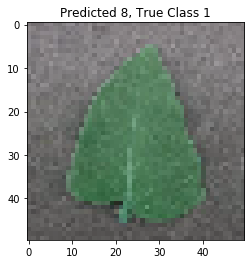

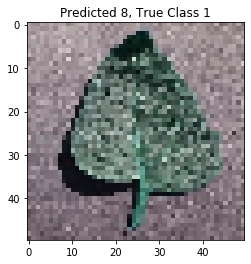

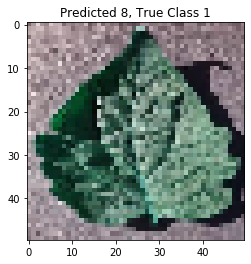

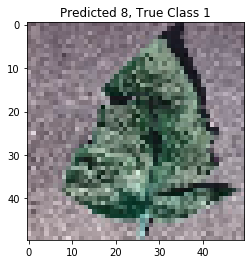

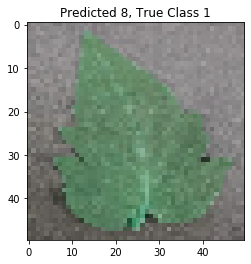

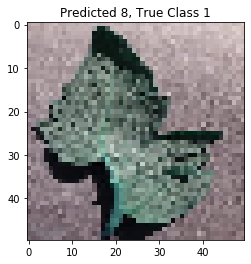

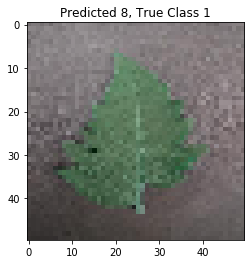

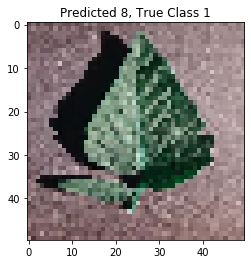

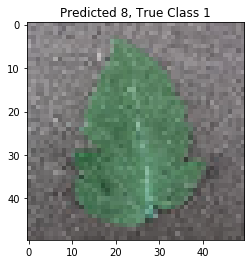

In [ ]:
predicted_classes = new_pruned_model.predict_classes(X_test.reshape(-1,50,50,3))
print(predicted_classes[343])
y_indices = np.argmax(y_test, axis=1)
for correct in np.arange(400,409):
    plt.imshow(X_test[correct].reshape(50,50,3), cmap='gray', interpolation='none')
    plt.title("Predicted {}, True Class {}".format(predicted_classes[correct], y_indices[correct]))
    plt.show()